In [1]:
from datetime import timedelta
import healpy
import huracanpy
import intake
from iris.analysis.cartography import wrap_lons
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm

/home/users/lsaffin/mambaforge/envs/wcrp_hackathon/lib/python3.12/site-packages/pyproj/network.py:59: UserWarning: pyproj unable to set PROJ database path.
  _set_context_ca_bundle_path(ca_bundle_path)


In [2]:
tracks = huracanpy.load("../hk25-TropCyc/TC_tracks/um_glm_n2560_RAL3p3.csv")
track = tracks.hrcn.sel_id(72)
track

<xarray.Dataset> Size: 5kB
Dimensions:       (record: 50)
Dimensions without coordinates: record
Data variables:
    track_id      (record) int64 400B 72 72 72 72 72 72 72 ... 72 72 72 72 72 72
    i             (record) int64 400B 2182 2182 2179 2176 ... 2309 2335 2365
    j             (record) int64 400B 1114 1117 1117 1120 ... 1451 1463 1480
    lon           (record) float64 400B 306.9 306.9 306.5 ... 324.8 328.4 332.6
    lat           (record) float64 400B 14.48 14.77 14.77 ... 46.08 47.2 48.8
    psl_min       (record) float64 400B 9.94e+04 9.873e+04 ... 9.795e+04
    sfcwind_max   (record) float64 400B 30.81 29.63 32.53 ... 21.38 21.09 21.09
    orog_max      (record) float64 400B 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    wind_max_925  (record) float64 400B 39.33 40.69 46.85 ... 35.54 35.19 36.21
    wind_max_850  (record) float64 400B 34.7 37.65 41.59 ... 35.2 35.67 37.08
    rh_avg_850    (record) float64 400B 80.18 81.13 80.4 ... 93.31 92.59 91.36
    time          (record) datetime64[ns] 400B 2020-09-10 ... 2020-09-22T06:0...

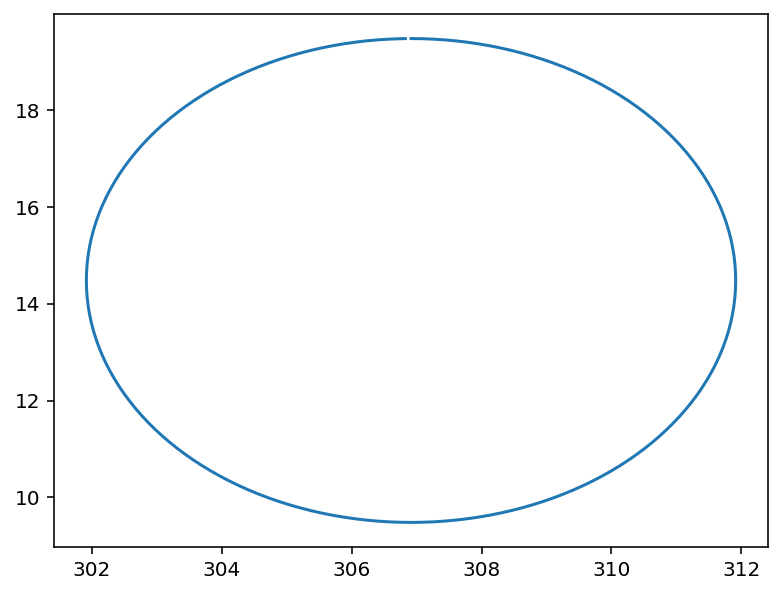

In [3]:
# Set up initial points. 5-degree circle around cyclone centre
x0 = track.lon.values[0]
y0 = track.lat.values[0]

angle = np.arange(360)

x0 = x0 + 5 * np.sin(np.deg2rad(angle))
y0 = y0 + 5 * np.cos(np.deg2rad(angle))

plt.plot(x0, y0)

In [4]:
cat = intake.open_catalog('https://digital-earths-global-hackathon.github.io/catalog/catalog.yaml')['online']
ds = cat["um_glm_n2560_RAL3p3"](zoom=9, time="PT3H").to_dask().sel(pressure=200)
ds

/home/users/lsaffin/mambaforge/envs/wcrp_hackathon/lib/python3.12/site-packages/intake_xarray/base.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  'dims': dict(self._ds.dims),


<xarray.Dataset> Size: 528GB
Dimensions:   (cell: 3145728, time: 3497)
Coordinates:
  * cell      (cell) int64 25MB 0 1 2 3 4 ... 3145724 3145725 3145726 3145727
    crs       float64 8B ...
    pressure  int64 8B 200
  * time      (time) datetime64[ns] 28kB 2020-01-20 ... 2021-04-01
Data variables: (12/14)
    cli       (time, cell) float32 44GB dask.array<chunksize=(4, 262144), meta=np.ndarray>
    clw       (time, cell) float32 44GB dask.array<chunksize=(4, 262144), meta=np.ndarray>
    hur       (time, cell) float32 44GB dask.array<chunksize=(4, 262144), meta=np.ndarray>
    hus       (time, cell) float32 44GB dask.array<chunksize=(4, 262144), meta=np.ndarray>
    qg        (time, cell) float32 44GB dask.array<chunksize=(4, 262144), meta=np.ndarray>
    qr        (time, cell) float32 44GB dask.array<chunksize=(4, 262144), meta=np.ndarray>
    ...        ...
    ua        (time, cell) float32 44GB dask.array<chunksize=(4, 262144), meta=np.ndarray>
    va        (time, cell) float32 44GB dask.array<chunksize=(4, 262144), meta=np.ndarray>
    wa        (time, cell) float32 44GB dask.array<chunksize=(4, 262144), meta=np.ndarray>
    zg        (time, cell) float32 44GB dask.array<chunksize=(4, 262144), meta=np.ndarray>
    orog      (cell) float64 25MB dask.array<chunksize=(98304,), meta=np.ndarray>
    sftlf     (cell) float64 25MB dask.array<chunksize=(98304,), meta=np.ndarray>
Attributes:
    Met Office DYAMOND3 simulations:  A group of experiments have been conduc...
    bounds:                           {'lower_left_lat': -90, 'lower_left_lon...
    latitiude_convention:             [-90, 90]
    longitude_convention:             [0, 360]
    regional:                         False
    simulation:                       glm.n2560_RAL3p3
    simulation_description:           The MetUM uses a regular lat-lon grid, ...

In [5]:
dy = 1.112e5  # Distance in m between 2 lat circles

def update_position(x, y, u, v, dt):
    # Calculate new positions
    x = x + u * dt / (dy * np.cos(np.deg2rad(y)))
    y = y + v * dt / dy

    # Crosses pole
    cross_north_pole = (y > 90)
    y[cross_north_pole] = 180 - y[cross_north_pole]

    cross_south_pole = (y < -90)
    y[cross_south_pole] = -180 + y[cross_south_pole]

    # Check boundaries
    x[cross_north_pole | cross_south_pole] += 180
    x = wrap_lons(x, base=-180, period=360)

    return x, y

# Default iterations from Lagranto
euler_iterations=3
times = pd.date_range(
    start=track.time.values[0],
    end=track.time.values[-1],
    freq="3h",
)
ntimes = len(times)

# Timestep in seconds (for 3-hourly data)
dt = 3 * 3600

# Preallocate array for trajectories and add initial positions
ntraj = len(x0)
trajectories = np.zeros([ntimes + 1, ntraj, 2])
trajectories[0, :, 0] = x0
trajectories[0, :, 1] = y0


for n, time in tqdm(enumerate(times), total=ntimes):
    # First iteration (x0, y0) == (x1, y1)
    x1 = x0
    y1 = y0

    ds_t = ds.sel(time=time)
    ds_tp1 = ds.sel(time=time + timedelta(seconds=dt))

    # Winds at t0
    u0 = healpy.get_interp_val(ds_t.ua, x0, y0, nest=True, lonlat=True)
    v0 = healpy.get_interp_val(ds_t.va, x0, y0, nest=True, lonlat=True)

    # Further iterations. Keep updating x1, y1
    for i in range(euler_iterations - 1):
        # Winds at t+dt
        u1 = healpy.get_interp_val(ds_tp1.ua, x1, y1, nest=True, lonlat=True)
        v1 = healpy.get_interp_val(ds_tp1.va, x1, y1, nest=True, lonlat=True)

        # Average velocity across times
        u = (u0 + u1) / 2.
        v = (v0 + v1) / 2.

        # Calculate new positions
        x1, y1 = update_position(x0, y0, u, v, dt)

    # Add final position to trajectories
    trajectories[n + 1, :, 0] = x1
    trajectories[n + 1, :, 1] = y1

    x0, y0 = x1, y1

np.save("um_n2560_glm_ral3p3_tc72_outflow_trajectories.npy", trajectories)
ds.close()

  7%|▋         | 7/99 [00:19<04:13,  2.76s/it]


KeyboardInterrupt: 